In [1]:
### Loading Video
import os
import av
import math
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

left_video = os.path.join("Nov30", "00_02.mp4")
right_video = os.path.join("Nov30", "04_02.mp4")

def load_video(video_path, sample_index):
    video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
    frame_counts = len(video)
    fps = meta['video_fps']
    print(frame_counts, fps)
    sample_frame = to_pil_image(video[sample_index])
    return video, frame_counts, fps, sample_frame
            

43 29.8807087982087


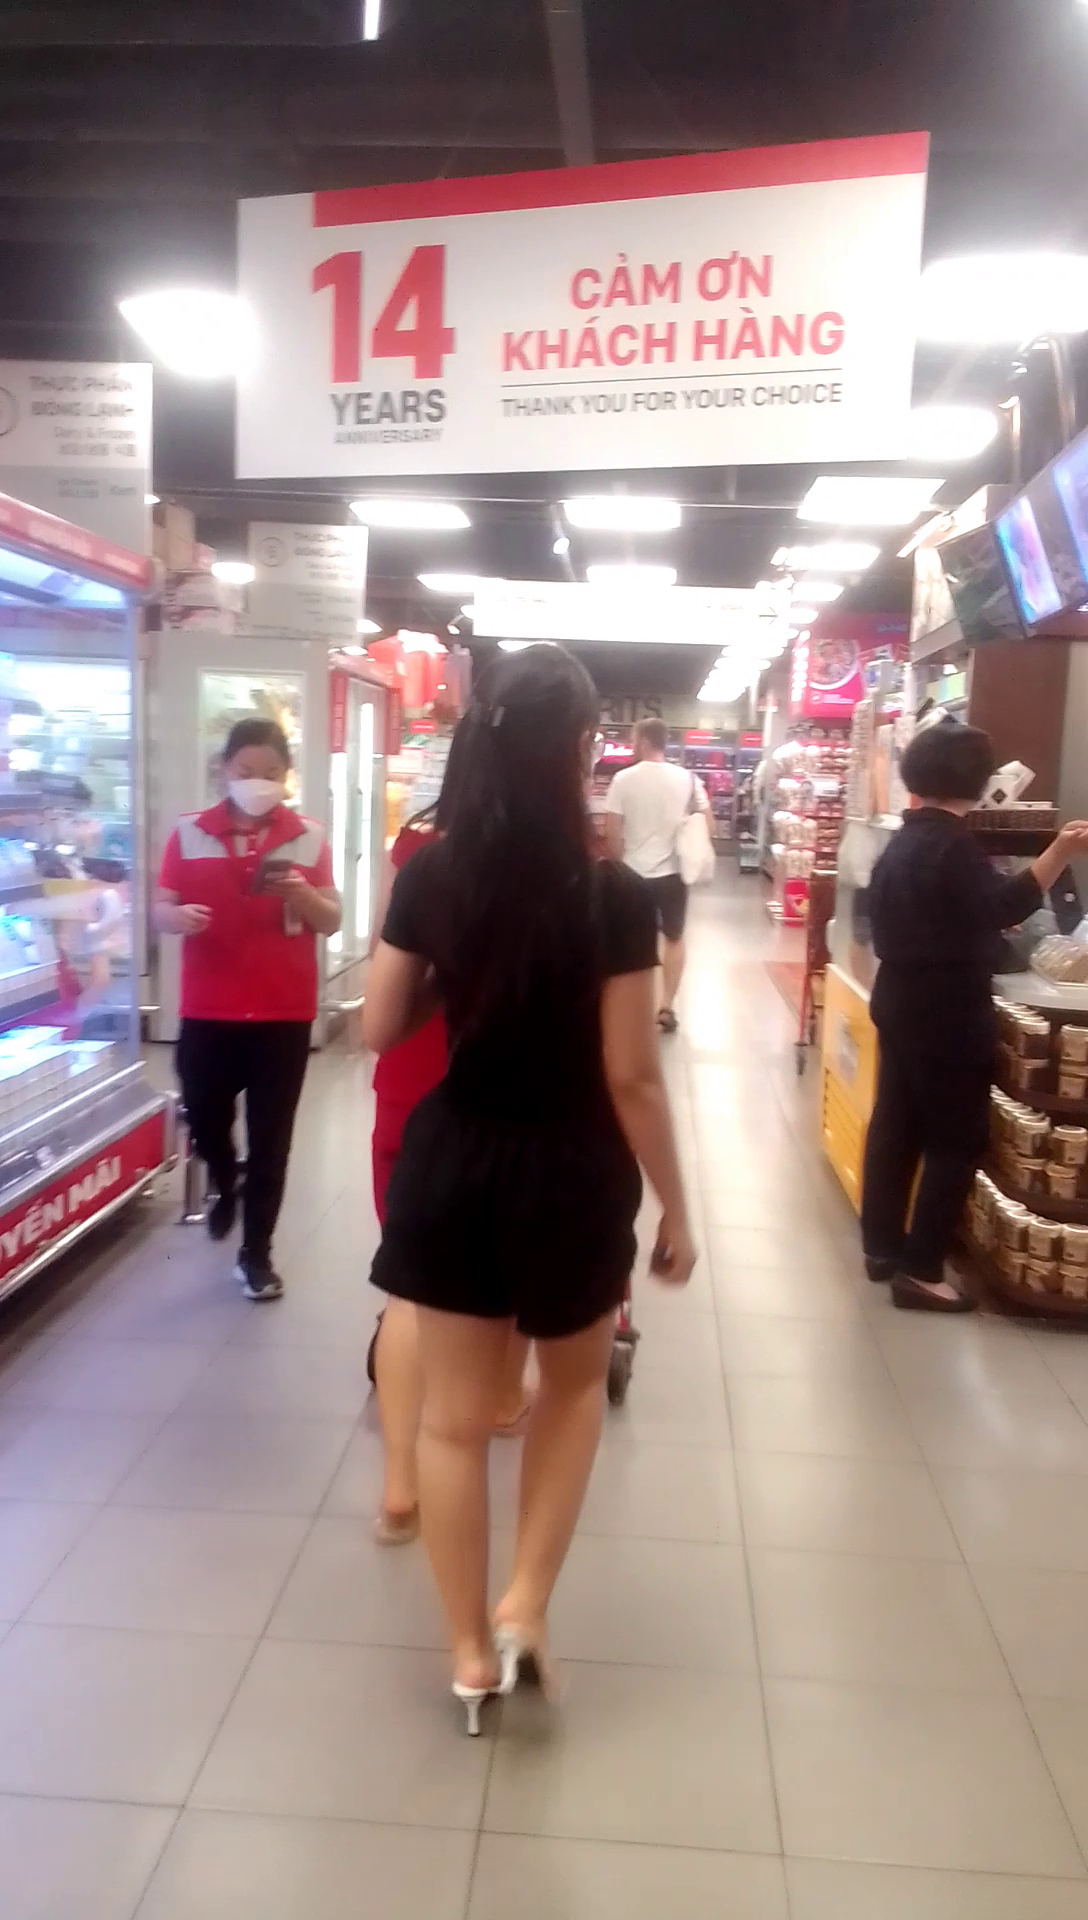

In [2]:
left_vid, left_counts, left_fps, left_sample = load_video(left_video, 10)
left_sample = left_sample.rotate(-90, expand=True)
left_sample

32 29.8804780876494


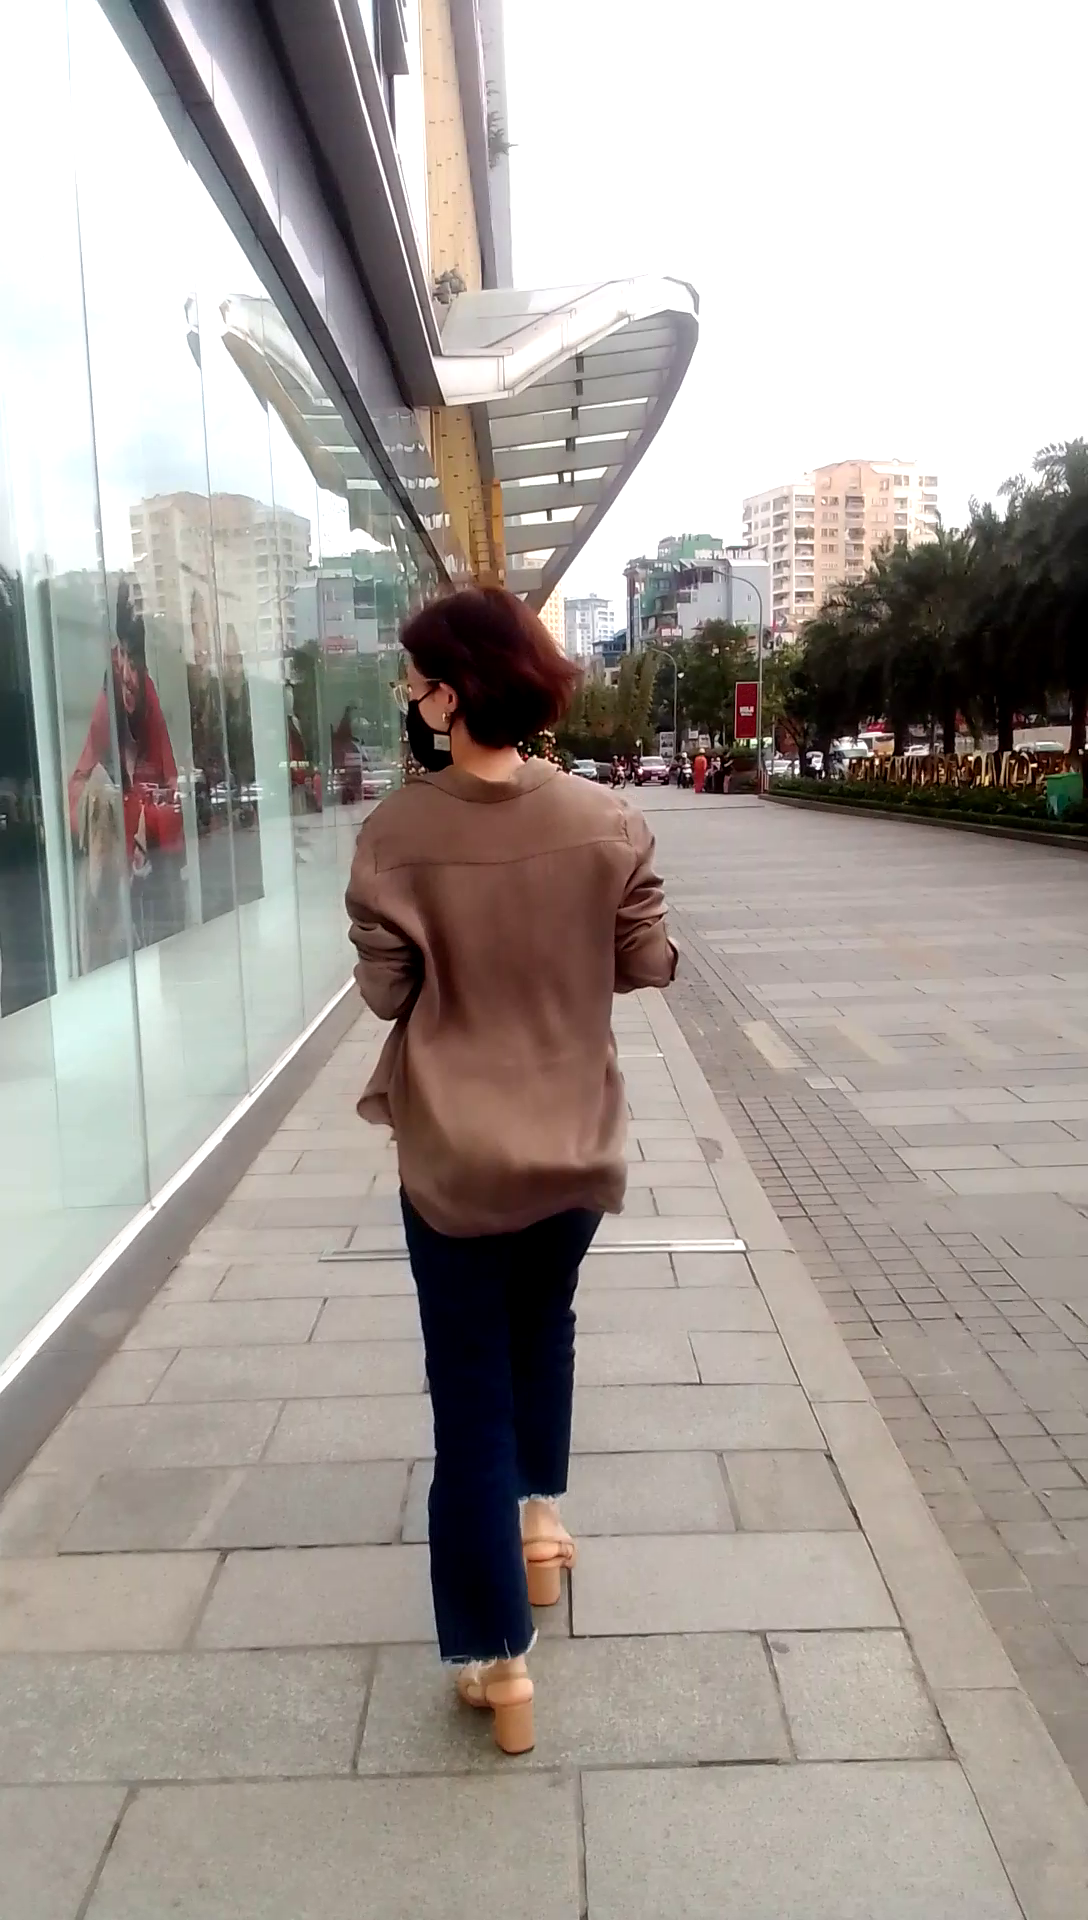

In [4]:
right_vid, right_counts, right_fps, right_sample = load_video(right_video, 2)
right_sample = right_sample.rotate(-90, expand=True)
right_sample

In [5]:
def bodyRatio(kp):
    ls = kp[0][5]
    rs = kp[0][6]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]

    def legToBack(s, h, a):
        return (a-h)/(h-s)

    def hipToShoulder(ls, rs, lh, rh):
        return (rh-lh)/(rs-ls)

    legRatio = legToBack(ls[1], lh[1], la[1])
    hipRatio = hipToShoulder(ls[0], rs[0], lh[0], rh[0])
    
    leg_back = round(legRatio.item(), 3)
    hip_shoulder = round( hipRatio.item(), 3)
    score = round(leg_back * hip_shoulder, 3)
    
    return score, leg_back, hip_shoulder

In [6]:
### Loading Keypoints Models
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model =  keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()

model.eval().to("cpu")

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [7]:
### Frame Keypoints Prediction and Visualization
import torch
from torchvision.utils import draw_keypoints, draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor

def detect(frame, min_scores, selector):
    ### Make Predictions on Frame
    body_matrix = transforms(frame)
    predictions = model([body_matrix.to("cpu")])

    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_scores)
    
    bx = torch.unsqueeze(boxes[idx][selector], dim=0)
    kp = torch.unsqueeze(keypoints[idx][selector], dim=0)
    score, legRatio, hipRatio = bodyRatio(kp)
    
    
    labels = [f'Score: {score}']
    print(labels[0])
    ### Draw Keypoints and Bounding Boxes
    tensor_image = pil_to_tensor(frame)
    keypoints_image = draw_keypoints(tensor_image, kp, colors="yellow", radius=3)
    final_image = draw_bounding_boxes(
        keypoints_image, 
        bx, 
        labels=labels, 
        colors="blue", 
        fill=True, 
        font="Arial",
        font_size=21
    )
    
    return to_pil_image(final_image)

Score: 1.112
Score: 0.899


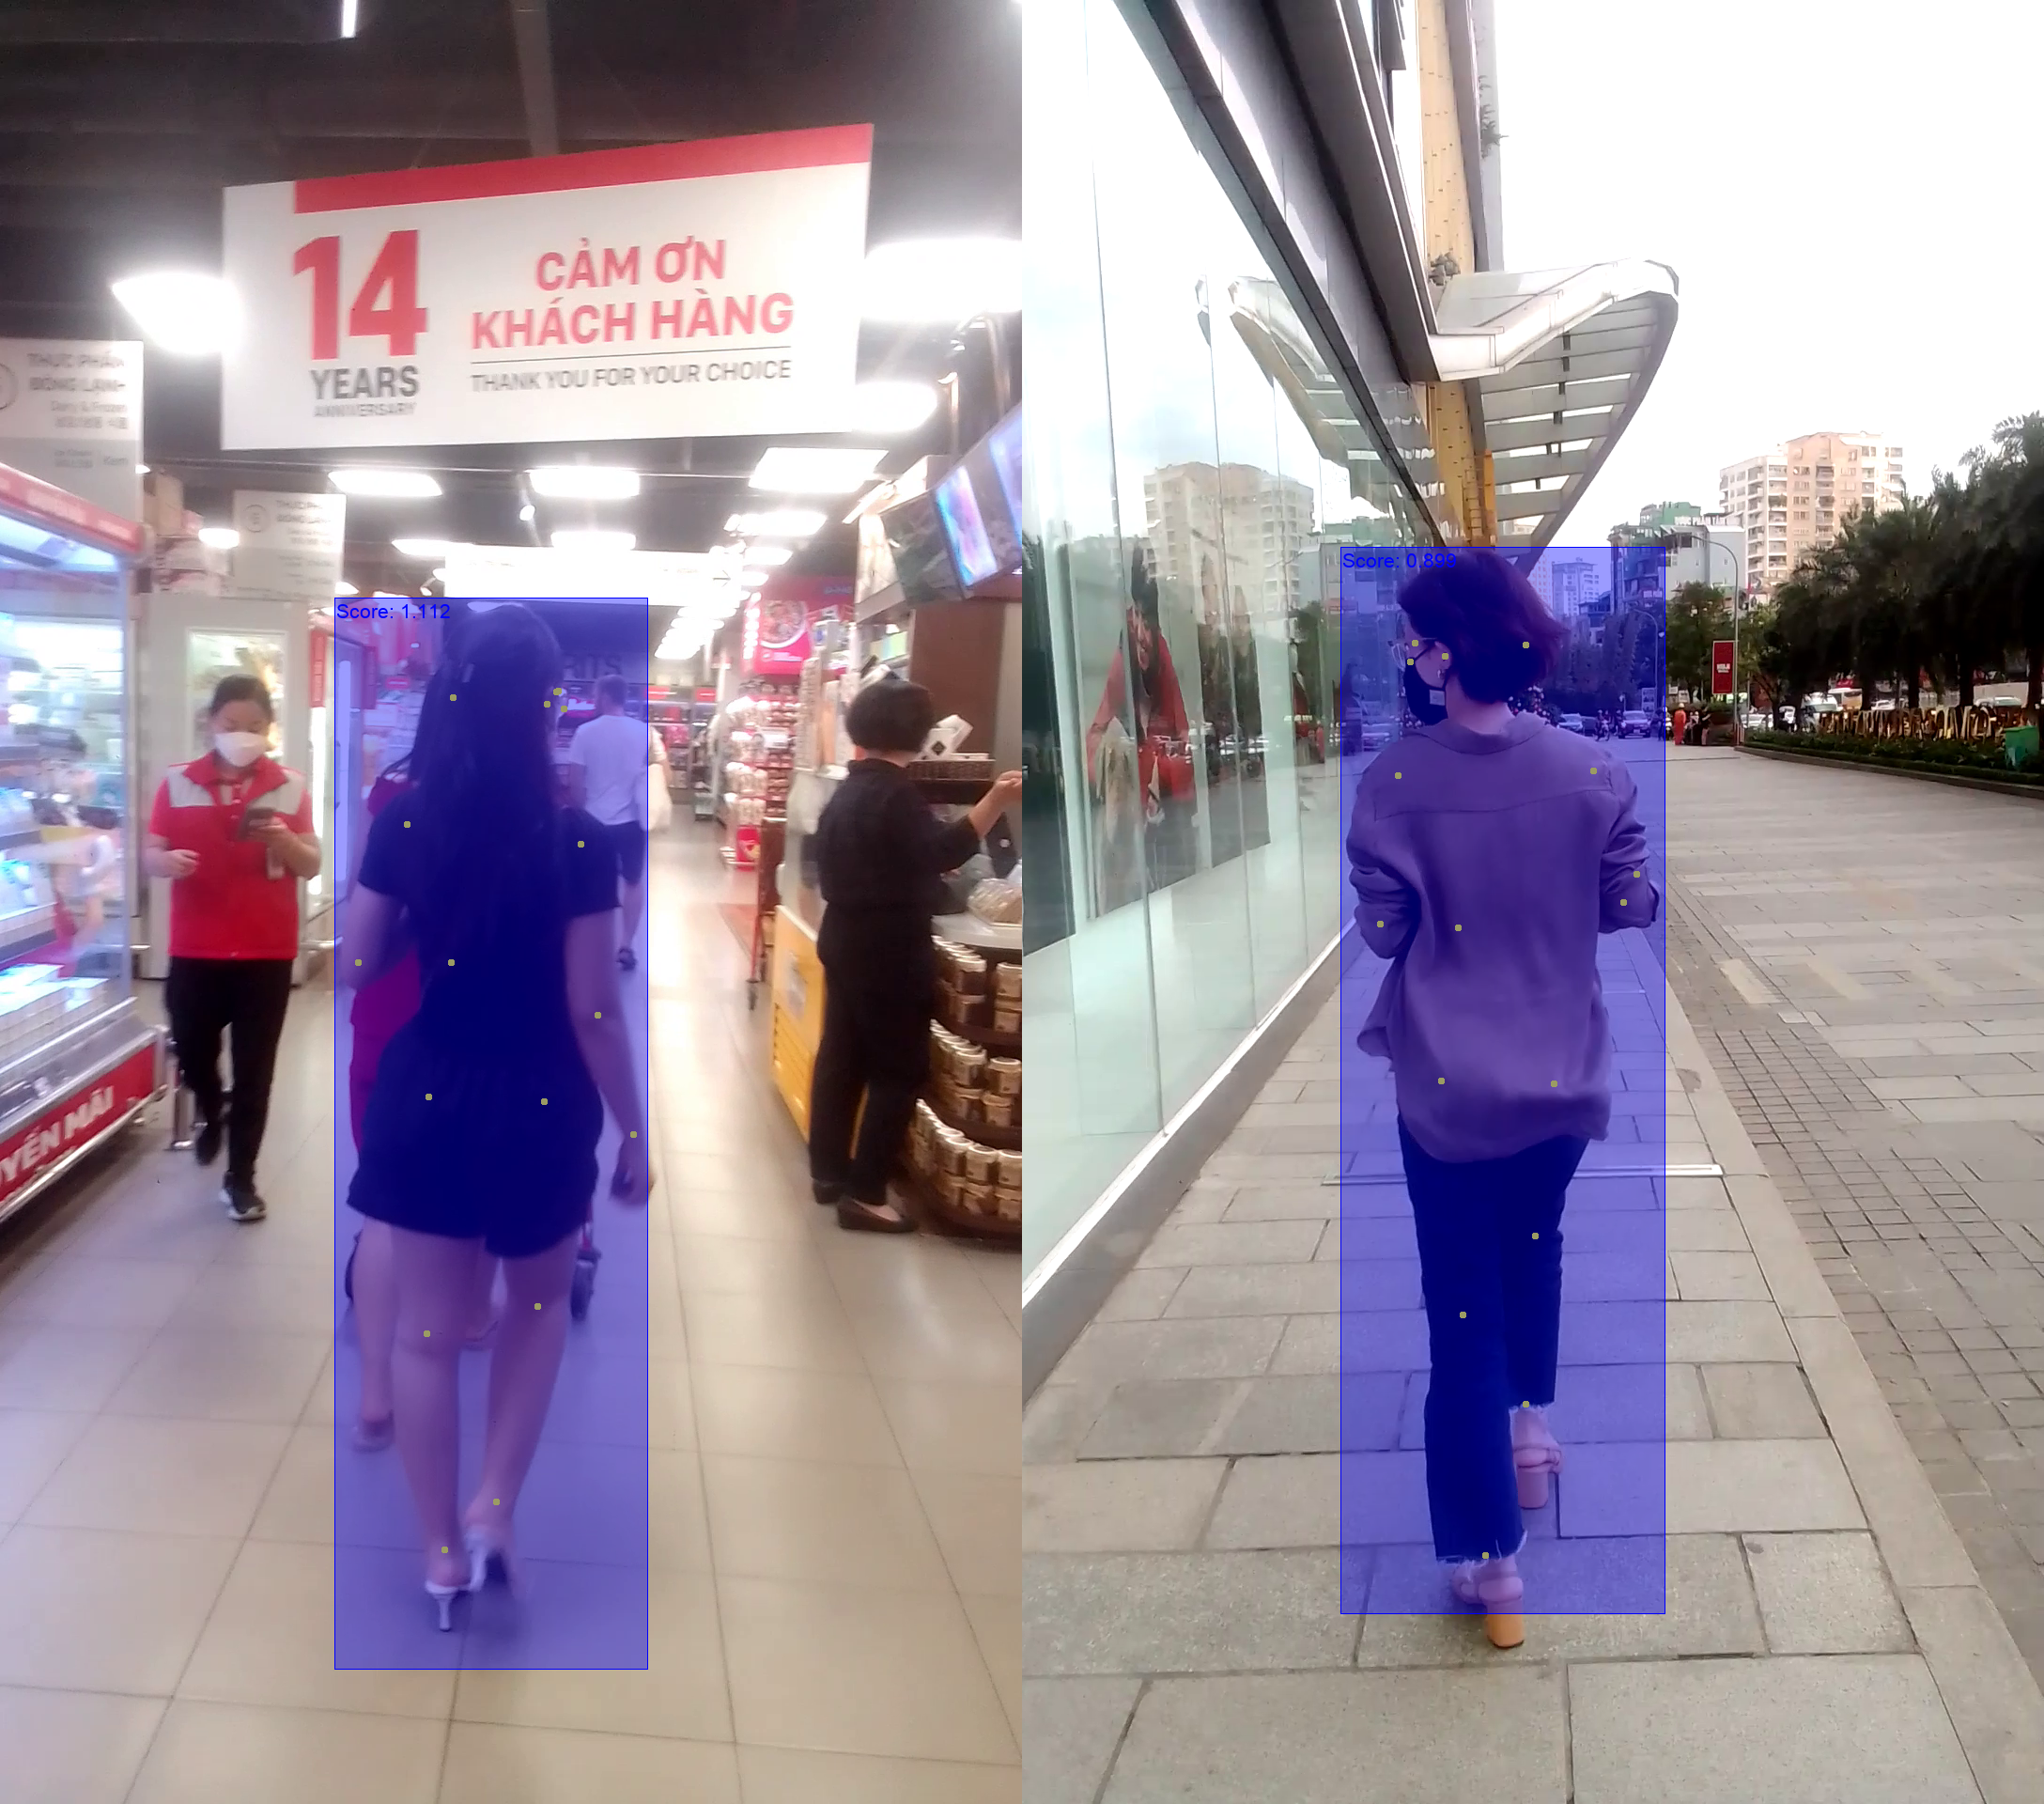

In [10]:
from PIL import Image

left_cal = detect(left_sample, 0.9, 2)
right_cal = detect(right_sample, 0.9, 0)

width = left_cal.width + right_cal.width
height = left_cal.height

left_right = Image.new("RGB",(width, height))
left_right.paste(im=left_cal, box=(0,0))
left_right.paste(im=right_cal, box=(right_cal.width, 0))

left_right

In [11]:
left_right.save("body_matrix_scores.jpg")